# Starting conditions

Two freshly recruited data scientists who knows how to code, have a fair understanding of statistics and the constrains of real life data project. Both of us have an affinity with unix environments, experience in python programming language and a geek culture to use shell tools to automatize tasks. Another common characteristic is that we both have a PhD in quantitative disciple. During this experience, we carry out our own research project with autonomy and perseverance in order to obtain original results. In addition, we have acquired transversal skills in written and oral communication, but also in project and time management. What we knew when we started.... (add points about what we learned in terms of project management during the phd ?)

On the definition of data scientist. Data scientist can have a rather broad definition. In our view it is someone who can handle a data oriented project in its entirety. It should comprise the overlapping of three distinct domains: the skills of a statistician who knows how to model and summarize datasets; the skills of a computer scientist who can design and use algorithms to efficiently store, process, and visualize this data; and the scientific perspective to ask the right questions and to put their answers in context. Most common tasks of a data scientist include project conception, tidying and exploring raw data, develop meaningful analysis, extract knowledge and information and communication an interesting and informative story. (This includes but is not limited to : project conception, data exploration/prep, developping meaningful analysis, extract knowledge not only information...) 

We took a kaggle competition as a trial project to help us acquire an experience in real world data issues without too much hassle on cleaning and getting the data. The objective of this competition is to contribute to fisheries monitoring by finding the best algorithm classifying into seven species pictures catched from fishing boats. For more details about the rules, please refer to [kaggle website](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring).

A consequence of the competition NDA, we can not share the pictures. The training dataset is divided in different categories with several annotated species with two extra classes : no fishes or other (whales, ...). The pictures are wide field shots from the several boats encompassing variations such as : day/night, multiplicity of fishes per picture, large fields of boat features,...

In the following sections you will find a summary of our discovery of image analysis and classification as close as possible to how we lived the experience.

# Stage 0 : How do you even analyze a single image ?

It is one thing to use softwares such as Photoshop (Adobe), or The Gimp, quite an other to think about images as matrices and how you can extract meaningful features from them. A few libraries exists to work with images, two major attracted our interest with the constrain that we essentially work with Python : [Scikit Image](http://scikit-image.org/) and [OpenCV](http://opencv.org/). We started to test quite a few things that one can do with an image with a naive perspective : color coding and their advantages, thresholding, segmentations, transformations, detection of interest points (SIFT, SURF, ORB, hessian of gaussian, laplacian of gaussian, ..) and probably a few forgotten ones.

In our hands even if scikit image was maybe a bit more intuitive with a very pythonic approach, OpenCV was much more stable and faster on operations such as color segmentation. There is only one counter intuitive hiccup which is that by default, OpenCV works with BGR color space and not RGB for it seems [historical reasons](https://www.learnopencv.com/why-does-opencv-use-bgr-color-format/).

One line of work that we tried was to take a few representative images and test how we could increase signal to noise ratio. Thresholding with Otsu was for example interesting but the fish often finished in the background region (black). One thing that was helpful was to perform color segmentation to globally remove noise and generate cartoon-like images. We first tried the methods implemented in scikit image but found out that for some images, the segmentation was impossible due to some implementation specificities. Once we realised that color segmentation could basically be done like [that](http://docs.opencv.org/3.1.0/d1/d5c/tutorial_py_kmeans_opencv.html), we added this step in our later trials to simplify the images:

signal to noise ratio?

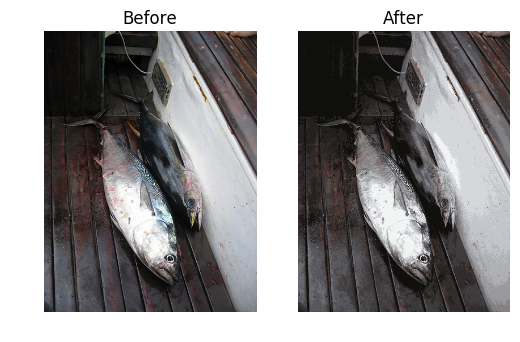

In [67]:
# source : http://docs.opencv.org/3.1.0/d1/d5c/tutorial_py_kmeans_opencv.html
from IPython.display import Image
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
# Plot inline
%matplotlib inline

# Picture from imagenet, in the spirit of pictures present in the dataset.
# source : 'http://farm3.static.flickr.com/2118/3537255216_d766eac288.jpg'
im = '3537255216_d766eac288.jpg'
img = cv2.imread(im)
# Color segmentation starts here
Z = img.reshape((-1, 3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# number of colors wanted in the final picture
K = 16
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

# The important part - Correct BGR to RGB channel
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res2 = cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)

# Plot shape of the mask and the detected keypoints
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False)
ax[0].set_aspect(aspect='auto', adjustable='box-forced')
ax[0].set_title('Before')
ax[0].axis('off')
ax[0].imshow(img)

ax[1].set_aspect(aspect='auto', adjustable='box-forced')
ax[1].set_title('After')
ax[1].axis('off')
ax[1].imshow(res2)
plt.show()

A basic preprocessing process used is the **histogram equalization**. It increases the image contrast using the image's histogram. It comes from the statement that a good image will have pixels with a large range of intensity values. This method consists in a palette transformation that distributes the pixels from a brighter region to a larger scope of brightness values. In order to avoid losing local contrast it can be done inside small regions of the image (adaptive), taking into account interpolations in tile borders. [OpenCV](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) has a implemented functions to perform global and adaptive histogram equalization as shown below. Please note that this method can only be used for brightness levels of the image and it can not be performed over images under *RGB* format, so brightness value has to be separated as in [YUV](https://en.wikipedia.org/wiki/YUV) levels. In this case, the global equalization reduces the maximal brightness values and increases contrast but it reduces the details on the bright side of the fish. On the other side, adaptive equalization increases global contrast of the picture and keeps important information inside the fish.

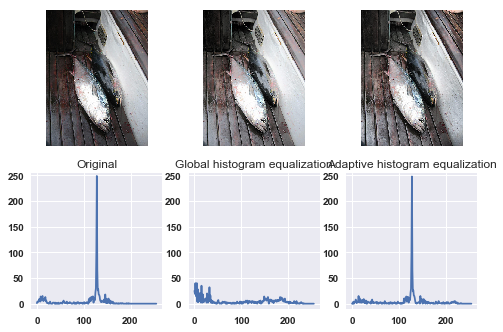

In [33]:
import cv2   
import matplotlib.pyplot as plt                                                                                                                                           
import seaborn as sns                                                                                                                                                     
                                                                                                                                                                          
# Read image                                                                                                                                                              
img = cv2.imread('3537255216_d766eac288.jpg')  
# transform to YUV  
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) 
# histogram for original image  
hist = cv2.calcHist(img_yuv,[0],None,[256],[0,256])
# recover original image in RGB format
img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)                                                                                                                        
# equalize the histogram of the Y channel                                                                                                                                 
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])                                                                                                                         
# transform the YUV image back to RGB format                                                                                                                                
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
# histrogram for global equalization
equ_hit = cv2.calcHist(img_output,[0],None,[256],[0,256])                                                                                                                 
# Create a Adaptive object (CLAHE).
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(4,4))                                                                                                               
# transform to YUV                                                                                                                                                  
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)                                                                                                                            
# apply adaptive equalization
img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])   
# transform the YUV image back to RGB format
cl1 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
# histogram for adaptive equalization
cl1_hist = cv2.calcHist(img_yuv,[0],None,[256],[0,256])     

# Plot                                                                                                                                     
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)                                                                                                                
ax1.imshow(img_rgb)                                                                                                                                                       
ax1.axis('off')                                                                                                                                                        
ax2.imshow(img_output)                                                                                                                                                    
ax2.axis('off')                                                                                                                                                       
ax3.imshow(cl1)                                                                                                                                                           
ax3.axis('off')                                                                                                                                                        
ax4.plot(hist)                                                                                                                                                            
ax4.set_title('Original')                                                                                                                                                 
ax4.set_ylim(-10, 255)
ax5.plot(equ_hit)                                                                                                                                                         
ax5.set_title('Global histogram equalization')  
ax5.set_ylim(-10, 255)
ax6.plot(cl1_hist)                                                                                                                                                        
ax6.set_title('Adaptive histogram equalization')     
ax6.set_ylim(-10, 255)
plt.show()

We next tried to generate a mask in order to remove background elements from the image such as **large** elements of the boats that are rather squarish and have homogeneous colors and then perform keypoint detection using [ORB](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html). The global idea is that once you have detected the keypoints, you can feed them to a classifier for increased accuracy. As you can see on the images below, it does enable us to remove regions for keypoint detection that surround the fishes, such a the floor or the elements in the top-middle region. This is just one example that is not in the dataset (see NDA), but on the images of the dataset, by playing with the number of colors and size of the elements we were actually able to remove quite a lot of non intersting features. At the same time, you can notice that some of the major elements are also lost such as the fins. They are extremely important in fish classification as their positions, proportions to each other and colors are key to fish species definition. For example, Yellow tuna fishes are called so because their fins have (among other things) caracteristic yellow color.

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


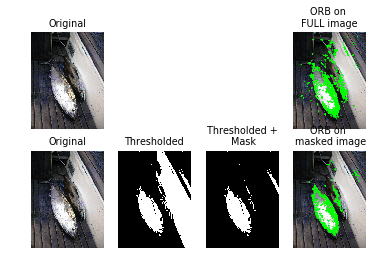

In [6]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

im = '3537255216_d766eac288.jpg'
img = cv2.imread(im)

# Perform keypoint detection on full image
orb = cv2.ORB_create(nfeatures=3000)
kp, descs = orb.detectAndCompute(img, None)
blobs_img_full = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)

blur = cv2.GaussianBlur(img, (3, 3), 0)
Z = blur.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 16
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((blur.shape))
# Convert to grayscale and apply otsu.
gray = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

# Noise removal by contour detection of large elements
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(thresh.shape, np.uint8)
mask2 = np.zeros(thresh.shape, np.bool)
# Remove large elements, typically boat structures 
for c in contours:
    # if the contour is not sufficiently large, ignore it
    # this parameter is highly dependant on the image size
    if cv2.contourArea(c) < 20000:
        continue
    cv2.drawContours(mask, [c], -1, (255, 255, 255), -1)
mask2[mask < 250] = True
masked = thresh * mask2
masked = cv2.cvtColor(masked, cv2.COLOR_GRAY2BGR)

# Perform keypoint detection on masked image
orb = cv2.ORB_create(nfeatures=3000)
kp, descs = orb.detectAndCompute(res2 * masked, None)
blobs_img = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)

# Plot shape of the mask and the detected keypoints
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(2, 4, sharex=False, sharey=False)

ax[0, 0].set_aspect(aspect='auto', adjustable='box-forced')
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')
ax[0, 0].imshow(img)

ax[0, 3].set_aspect(aspect='auto', adjustable='box-forced')
ax[0, 3].set_title('ORB on \nFULL image')
ax[0, 3].axis('off')
ax[0, 3].imshow(blobs_img_full)

ax[0, 1].axis('off')
ax[0, 2].axis('off')

ax[1, 0].set_aspect(aspect='auto', adjustable='box-forced')
ax[1, 0].set_title('Original')
ax[1, 0].axis('off')
ax[1, 0].imshow(img)

ax[1, 1].set_aspect(aspect='auto', adjustable='box-forced')
ax[1, 1].set_title('Thresholded')
ax[1, 1].axis('off')
ax[1, 1].imshow(thresh, cmap=plt.cm.gray)

ax[1, 2].set_aspect(aspect='auto', adjustable='box-forced')
ax[1, 2].set_title('Thresholded +\n Mask')
ax[1, 2].axis('off')
ax[1, 2].imshow(masked, cmap=plt.cm.gray)

ax[1, 3].set_aspect(aspect='auto', adjustable='box-forced')
ax[1, 3].set_title('ORB on \n masked image')
ax[1, 3].axis('off')
ax[1, 3].imshow(blobs_img)

plt.show()


# Stage 1 : Follow tutorials for machine learning

As we were two working on the problem, we thought we could test two radically different approaches to develop a broader scope of learning : the state-of-the-art Deep learning Approaches but also more classical classifiers such as Support Vector Machine classifiers or Boosted trees (xgboost) 
- **Deep learning** : In recent years, the use of convolutional networks did tremdously increase the accuracy of image classification (LINKS TO OTHER KAGGLES). They present ....
  - Advantages and inconviniets (perfomance vs calculation time)

- **Boosted Trees** : This kind of classifiers attracted our attention in the frame of a tutorial presenting the "Bag of features" approach. In this approach to image classification, a first step enables the extraction of meaningful features from images before submitting them  to a classifier. Our lab had previous success using the [xgboost](https://github.com/dmlc/xgboost) library, so we wanted to give it a try.
    - Feature extraction : In this approach, you define the features to extract from the images, convert them into vectors and feed them into a classifier. Following tutorials we ended up as our best approach to extract two major vectors. The first is simply the color histogram of the picture and the second one used SURF keypoint detector. Keypoints for every picture are first exctracted by SURF that generate a fixed sized monodimensional vector. The importance of redundant vectors is then assessed by clustering them using [K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) in order to detect which element of the pictures are to be highlighted. The final step to then count how many times per picture a common feature is present and build a vector (see : [ Building Maching Learning Systems with Python](https://www.packtpub.com/big-data-and-business-intelligence/building-machine-learning-systems-python) for reference).
    - Classification optimisation : using xgboost...
    

Finally we tried to validate our approaches on the public leaderboard. This was extermely discouraging as we got extremely bad logloss scores. We were rather convinced that we were not overfitting. In the end, that was quite not the issue. 

# Stage 2 : Understand deeply your data

As a follow up, we started to really get to know the dataset, deeply. First of all, the pictures are taken from cameras, this means that some shots are actually successive images from one scene. We could also notice that we have day/night pictures, a large variety of conditions (fog/rain/...).

Even if approaches such as convnet were extracting features automatically, we started to think like old times botanists : what set of features enables you to visually, with our own words to discriminate between two species ? Do we even have a chance to distinguish them ?
Well.. yes to some extend. The sharks have fins with very caracteristic shapes, Yellow fish have their color (yes, yellow) and so on for all of them. Exception made of Albacore and Big eye tuna that have very little difference. The length of their side fins seems to vary (thank you [wikipedia](http://www.wikipedia.org) but when we looked at the pictures we had, this was not something really visible.

An other observation that was made on the Kaggle forums was the importance of the boats. Indeed, in classical training, you randomly divide your pictures between training and validation sets. In this specific case, you often induce a clustering of images from the same boats (they are not so many) in either training or validation sets yielding to highly overfitting systems that poorly generalize. We then devised a splitting of the images that would allow a fair separation of the pictures having pictures from boats in the validation set that have never been seen by the training set. Once we did that, we started to have scores that were homogenous between our training, validation and online testing scores. 

# Stage 3 : The limits of simplicity

Our solution as a balance between complexity and time spent on the project

## Stage 3.1 : Preprocessing improvements

- Crop and rotate images (CNN using regression)
- Histogram equalization to improve contract

# Stage 4 : What it is likely to take to win

As budding data scientists, we also had a large span of attention towards project management, customer project definition and such things. One thing we felt is that we did try enough to get extremely good at image classification, but once again we started from scratch. When you read blog posts of people who actually won competitions, it takes experience and a massive amount of iterations to test tons of ideas and models. In this respect we did not exactely started as champions.
The next step, given we could spend more energy on this project encompass to try things like :
    - object detection to identify caracteristic elements of the fishes such as the fins, the ir size or their color.
    - r-cnn, more complex network,...
    - ...

# Conclusion

Redefinition of data scientist.
A working data scientist has to balance things and put them into perspective depending on the number of projects he/she works on. 
We did not have the time to go into fully custom algorithms for a winning solution (or a very good one). On allocated time frame we did learn a lot (collaborative approach, IT skills, image analysis skills, ...). We did not provide the best approach 
Final words, the algorithms are not the only ones that learn, we do too and as long as we keep learning we are on the right tracks. Maybe next time ?